<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/tianchi_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget  https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531860/suichang_round1_train_210120.zip

--2021-02-02 15:26:18--  https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531860/suichang_round1_train_210120.zip
Resolving tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)... 118.31.232.194
Connecting to tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)|118.31.232.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3038725742 (2.8G) [application/zip]
Saving to: ‘suichang_round1_train_210120.zip’

suichang_round1_tra  81%[===============>    ]   2.30G  43.4KB/s    in 11m 38s 

2021-02-02 15:53:02 (3.38 MB/s) - Read error at byte 2470361157/3038725742 (Success). Retrying.

--2021-02-02 15:53:03--  (try: 2)  https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531860/suichang_round1_train_210120.zip
Connecting to tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)|118.31.232.194|:443... connected.
HTTP r

In [ ]:
!unzip suichang_round1_train_210120.zip

In [ ]:
!wget https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531860/suichang_round1_test_partA_210120.zip

--2021-02-02 16:09:51--  https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531860/suichang_round1_test_partA_210120.zip
Resolving tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)... 118.31.232.194
Connecting to tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)|118.31.232.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 555925814 (530M) [application/zip]
Saving to: ‘suichang_round1_test_partA_210120.zip’

suichang_round1_tes 100%[===================>] 530.17M  5.82MB/s    in 81s     

2021-02-02 16:11:22 (6.58 MB/s) - ‘suichang_round1_test_partA_210120.zip’ saved [555925814/555925814]



In [ ]:
!unzip suichang_round1_test_partA_210120.zip

In [6]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A ## albumentations is a fast image augmentation library and easy to use wrapper around other libraries.

In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
torch.backends.cudnn.enabled = True

import torchvision
from torchvision import transforms as T

In [8]:
! nvidia-smi

Thu Feb  4 08:38:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
EPOCHES = 20
BATCH_SIZE = 16
IMAGE_SIZE = 256
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu' 
## data augmentation
trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
])


In [10]:
class TianChiDatasetshow(D.Dataset):
    def __init__(self, paths, transform, test_mode=False):
        self.paths = paths
        self.transform = transform
        self.test_mode = test_mode
        
        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            # T.ToTensor(),
            # T.Normalize([0.625, 0.448, 0.688],
            #             [0.131, 0.177, 0.101]),
        ])
        
    # get data operation
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if not self.test_mode:
            mask = cv2.imread(self.paths[index].replace('.tif', '.png')) - 1
            mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][:, :, 0].astype(np.int64)
        else:
            return self.as_tensor(img), ''        
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [11]:
import glob
dataset = TianChiDatasetshow(
    glob.glob('/content/suichang_round1_train_210120/*.tif'),
    trfm, False
)


In [12]:
dataset.len

16017

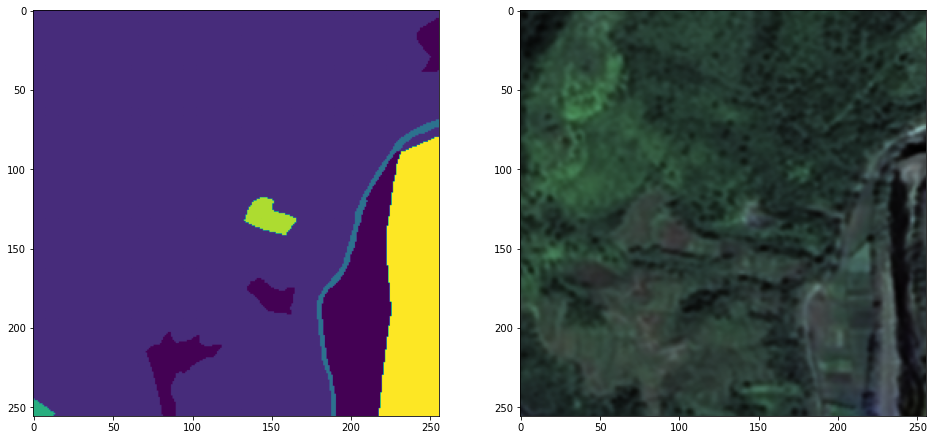

In [13]:
image, mask = dataset[150]

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(image);

In [14]:
class TianChiDataset(D.Dataset):
    def __init__(self, paths, transform, test_mode=False):
        self.paths = paths
        self.transform = transform
        self.test_mode = test_mode
        
        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
        
    # get data operation
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if not self.test_mode:
            mask = cv2.imread(self.paths[index].replace('.tif', '.png')) - 1
            mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][:, :, 0].astype(np.int64)
        else:
            return self.as_tensor(img), ''        
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [15]:
dataset_1 = TianChiDataset(
    glob.glob('/content/suichang_round1_train_210120/*.tif'),
    trfm, False
)

In [16]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(True)
    
#     pth = torch.load("/input/pretrain-coco-weights-pytorch/fcn_resnet50_coco-1167a1af.pth")
#     for key in ["aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias"]:
#         del pth[key]
    
    model.classifier[4] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
    return model

@torch.no_grad()
def validation(model, loader, loss_fn):
    val_iou = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.to(DEVICE)
        output = model(image)
        output = output.argmax(1)
        iou = np_iou(output, target)
        val_iou.append(iou)
        
    return val_iou


def np_iou(pred, mask, c=10):
    iou_result = []
    for idx in range(c):
        p = (mask == idx).int().reshape(-1)
        t = (pred == idx).int().reshape(-1)

        uion = p.sum() + t.sum()
        overlap = (p*t).sum()
        
        # print(idx, uion, overlap)
        
        iou = 2*overlap/(p.sum() + t.sum() +0.001)
        iou_result.append(iou.abs().data.cpu().numpy())
    return np.stack(iou_result)


In [17]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 71kB 5.7MB/s 
     |████████████████████████████████| 245kB 16.7MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=cb1cd71a370442684ae88d1e0b8570d1aa3d8f48735214266d3c5650712449c1
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=aaf4305ca7ba83f01238401c0f820d785b224b675767d550cdbf376be768d9b9
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [18]:
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'
print(header)
class_name = ['farmland','forest','grass','road','urban_area',
                 'countryside','industrial_land','construction',
                 'water', 'bareland']
print('  '.join(class_name))

valid_idx, train_idx = [], []

#for fold_idx in range(4,6):
for i in range(len(dataset_1)):
    if i % 5 == 0:
        valid_idx.append(i)
    else:
#     elif i % 7 == 1:
        train_idx.append(i)

train_ds = D.Subset(dataset_1, train_idx)
valid_ds = D.Subset(dataset_1, valid_idx)

# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,num_workers=4)

vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False,num_workers=4)

import segmentation_models_pytorch as smp
model = smp.Unet(
        encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pretreined weights for encoder initialization
        in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
        classes=10,                      # model output channels (number of classes in dataset)
)
model.to(DEVICE);
optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)
loss_fn = nn.CrossEntropyLoss().to(DEVICE);

best_iou = 0
for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    model.to(DEVICE);
    for image, target in tqdm_notebook(loader):

        image, target = image.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)

        # break
        loss = loss_fn(output, target)
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

    viou = validation(model, vloader, loss_fn)
    print('\t'.join(np.stack(viou).mean(0).round(3).astype(str)))

    print(raw_line.format(epoch, np.array(losses).mean(), np.mean(viou),
                              (time.time()-start_time)/60**1))    
    if best_iou < np.stack(viou).mean(0).mean():
        best_iou = np.stack(viou).mean(0).mean()
        torch.save(model.state_dict(), 'model_{0}.pth'.format(5))
          
#  break


        Train | Valid
Epoch |  Loss |  Loss | Time, m

farmland  forest  grass  road  urban_area  countryside  industrial_land  construction  water  bareland


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



0.638	0.922	0.0	0.016	0.004	0.455	0.001	0.0	0.587	0.0
     1│  0.783│  0.262│  5.34



0.697	0.928	0.0	0.176	0.114	0.472	0.0	0.0	0.656	0.0
     2│  0.429│  0.304│  5.42



0.714	0.936	0.0	0.24	0.1	0.556	0.011	0.0	0.675	0.0
     3│  0.388│  0.323│  5.42



0.692	0.926	0.0	0.206	0.153	0.577	0.156	0.0	0.672	0.0
     4│  0.370│  0.338│  5.43



0.717	0.935	0.0	0.223	0.13	0.582	0.135	0.0	0.665	0.0
     5│  0.356│  0.339│  5.43



0.728	0.938	0.0	0.233	0.172	0.594	0.193	0.0	0.681	0.0
     6│  0.342│  0.354│  5.43



0.723	0.939	0.0	0.266	0.182	0.58	0.151	0.0	0.717	0.0
     7│  0.332│  0.356│  5.43



0.701	0.936	0.0	0.27	0.128	0.597	0.148	0.001	0.71	0.0
     8│  0.323│  0.349│  5.44



0.746	0.94	0.0	0.205	0.139	0.621	0.184	0.013	0.717	0.0
     9│  0.314│  0.357│  5.42



0.707	0.937	0.0	0.275	0.145	0.605	0.143	0.028	0.722	0.0
    10│  0.308│  0.356│  5.41



0.743	0.939	0.0	0.25	0.153	0.589	0.201	0.079	0.714	0.0
    11│  0.300│  0.367│  5.41



0.751	0.943	0.008	0.259	0.139	0.63	0.174	0.087	0.727	0.0
    12│  0.294│  0.372│  5.41



0.708	0.93	0.035	0.292	0.164	0.629	0.208	0.105	0.722	0.0
    13│  0.288│  0.379│  5.41



0.751	0.945	0.095	0.295	0.196	0.635	0.206	0.103	0.73	0.0
    14│  0.291│  0.396│  5.41



0.764	0.944	0.093	0.293	0.199	0.646	0.166	0.108	0.74	0.0
    15│  0.277│  0.395│  5.41



0.746	0.942	0.134	0.277	0.2	0.608	0.191	0.144	0.731	0.007
    16│  0.273│  0.398│  5.41



0.763	0.944	0.129	0.301	0.184	0.639	0.164	0.132	0.738	0.023
    17│  0.268│  0.402│  5.41



0.742	0.941	0.135	0.273	0.204	0.646	0.235	0.161	0.731	0.017
    18│  0.264│  0.408│  5.41



0.685	0.934	0.097	0.283	0.195	0.603	0.216	0.165	0.684	0.013
    19│  0.258│  0.387│  5.41



0.769	0.948	0.166	0.3	0.191	0.657	0.256	0.181	0.755	0.029
    20│  0.254│  0.425│  5.42


KeyboardInterrupt: ignored

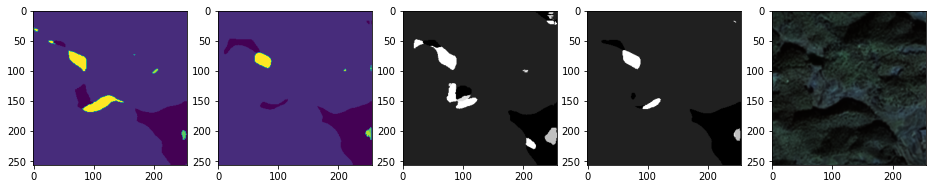

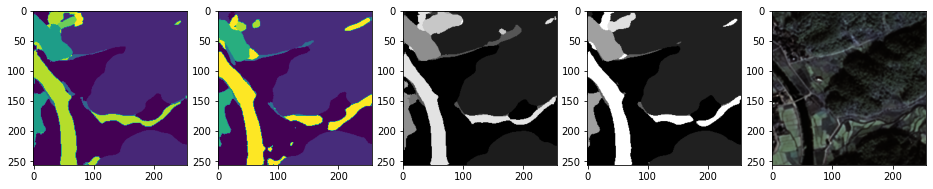

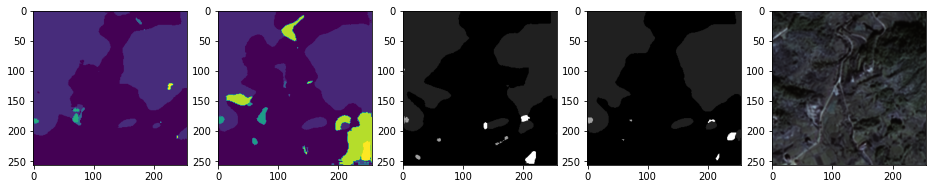

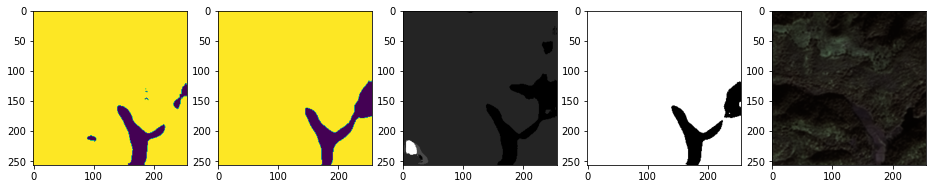

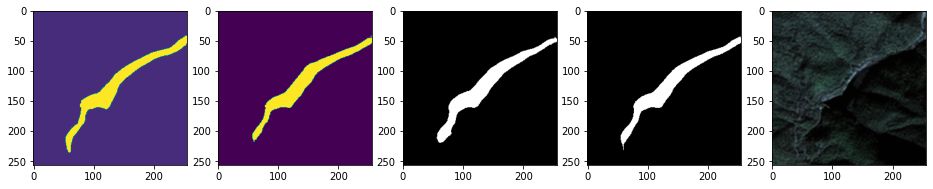

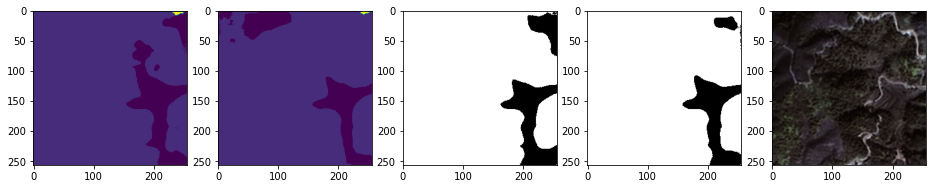

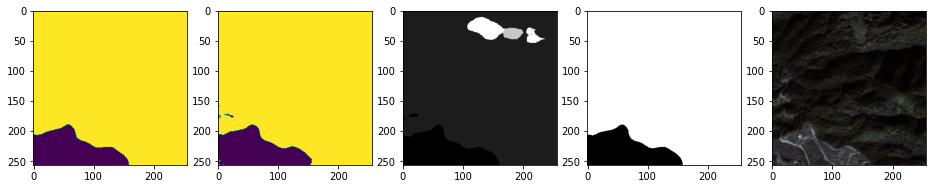

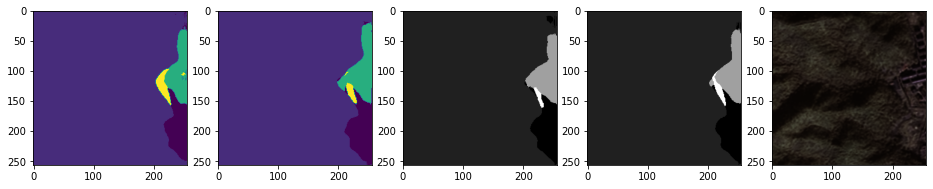

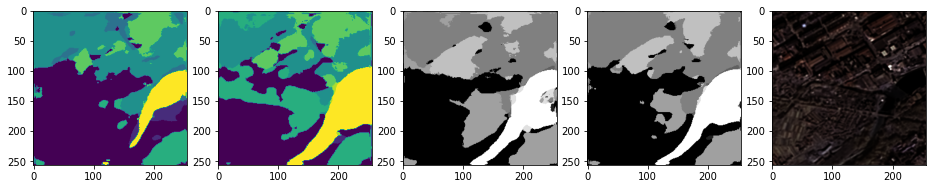

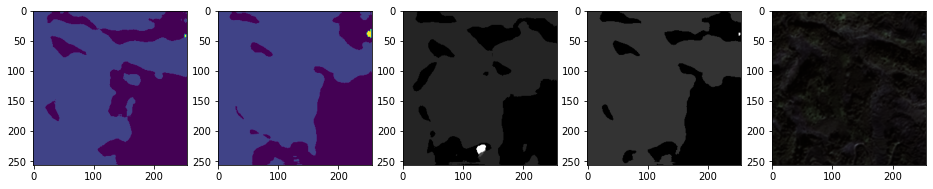

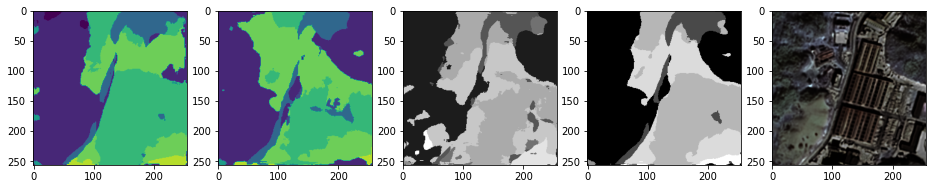

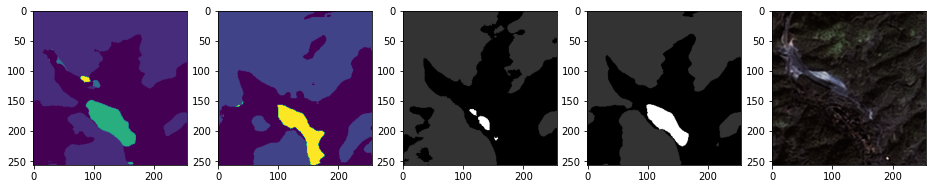

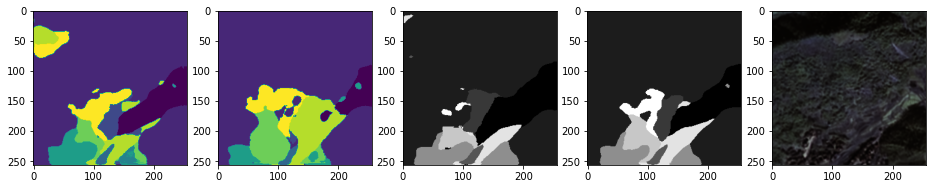

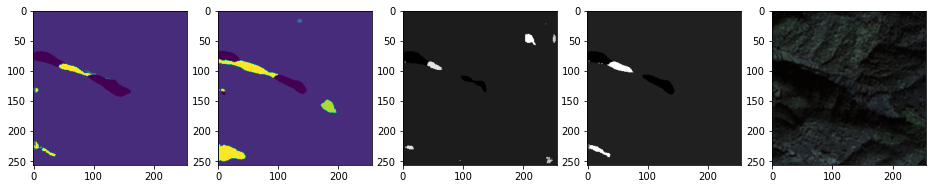

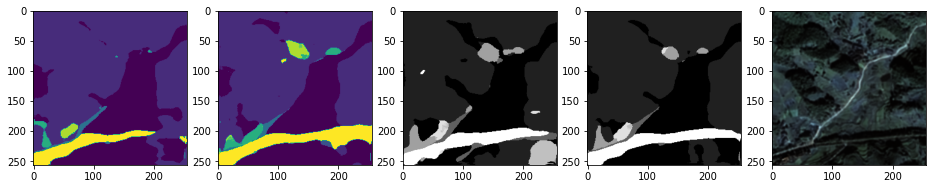

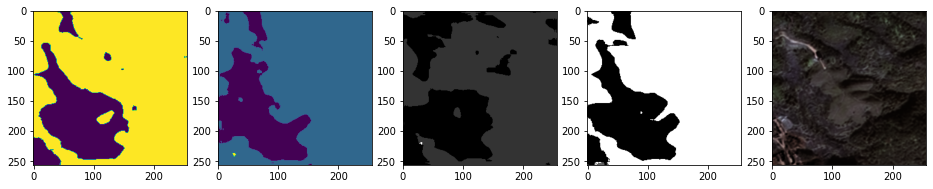

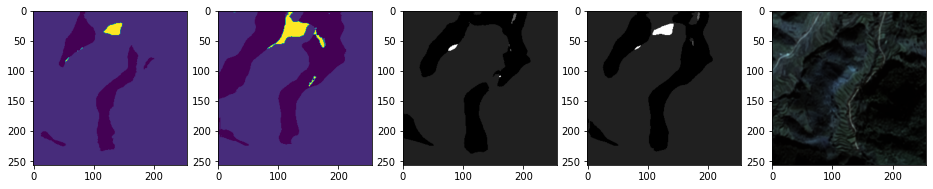

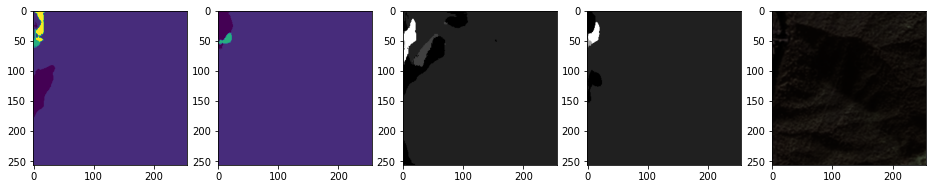

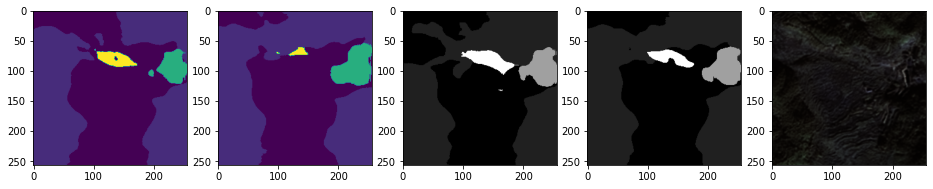

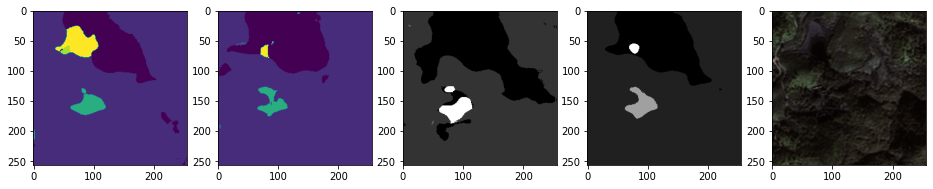

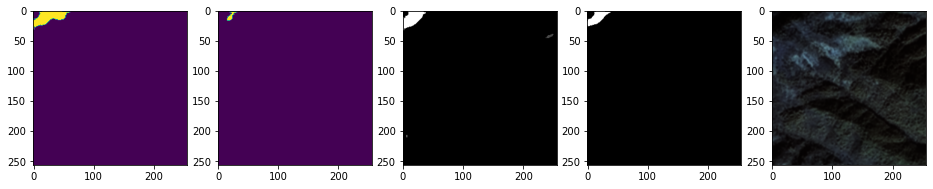

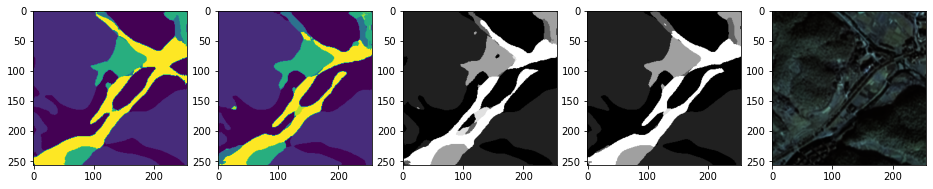

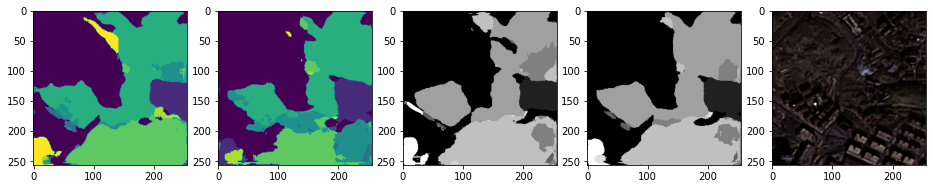

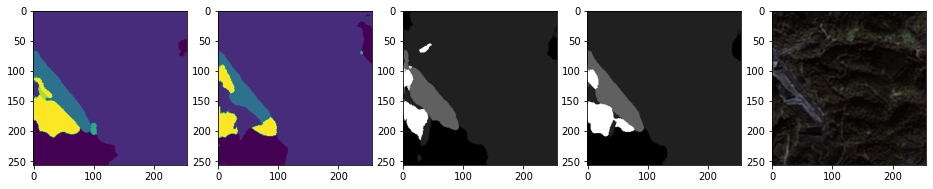

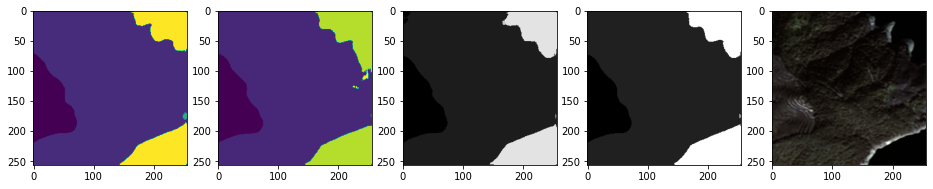

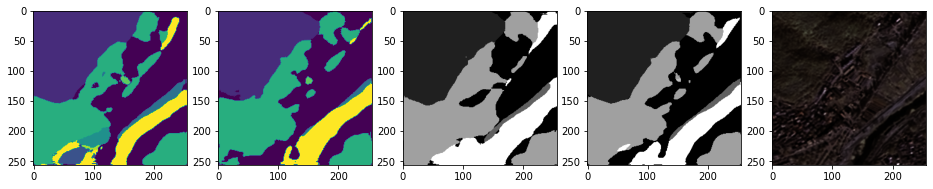

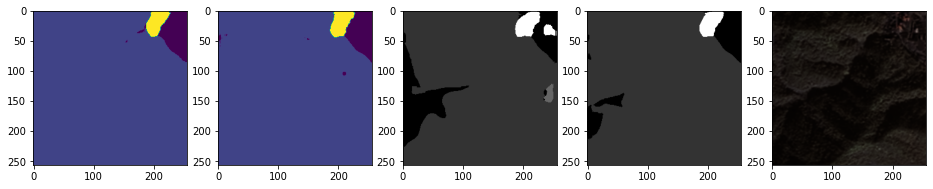

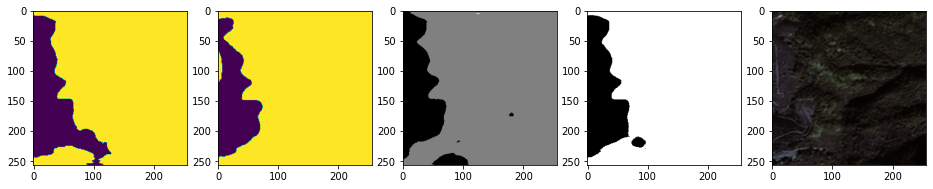

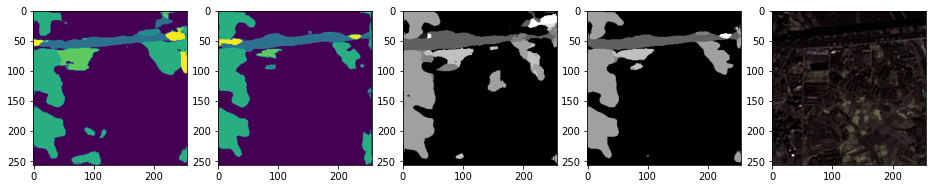

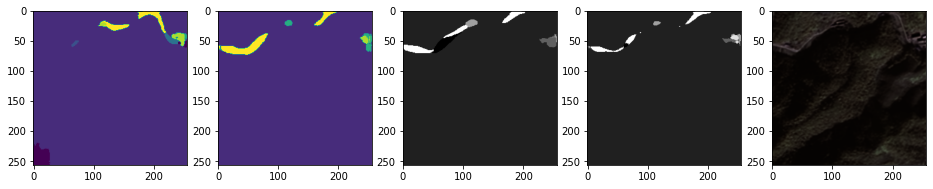

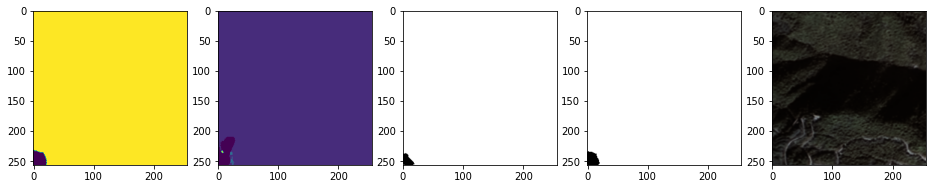

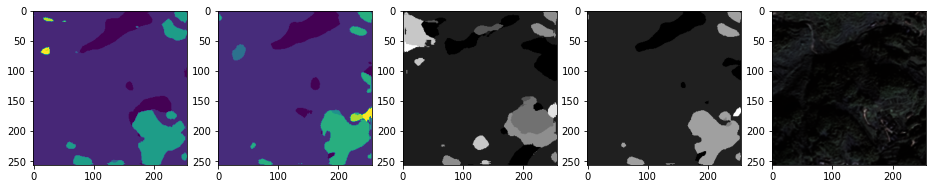

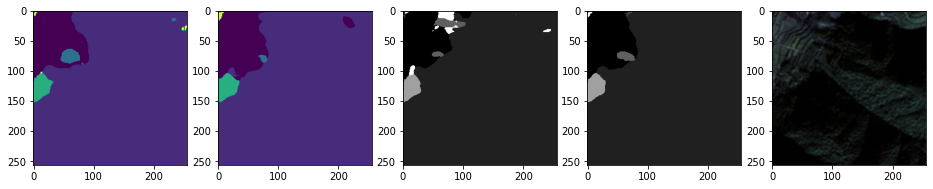

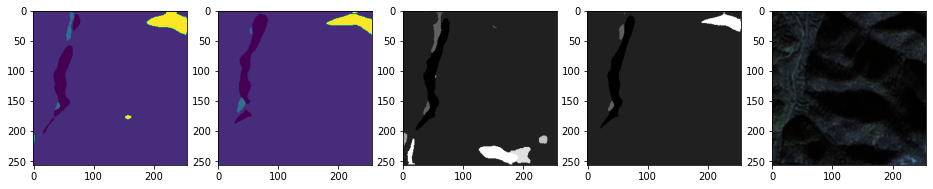

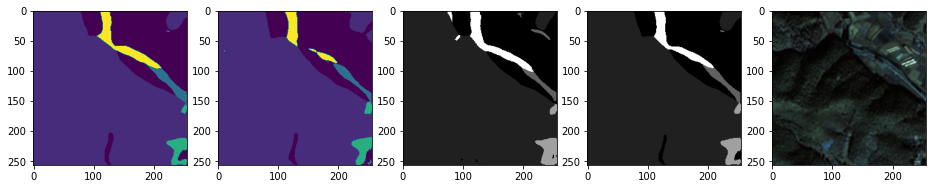

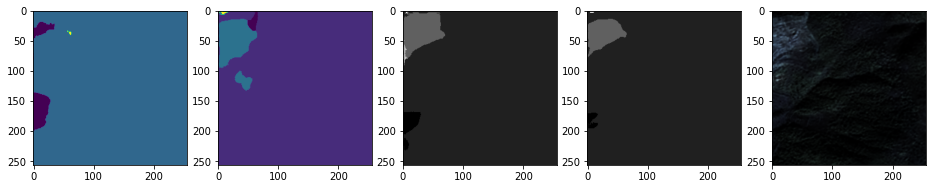

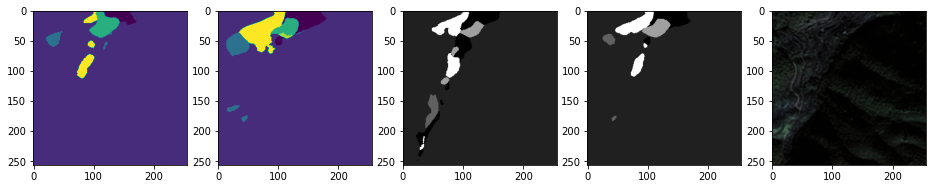

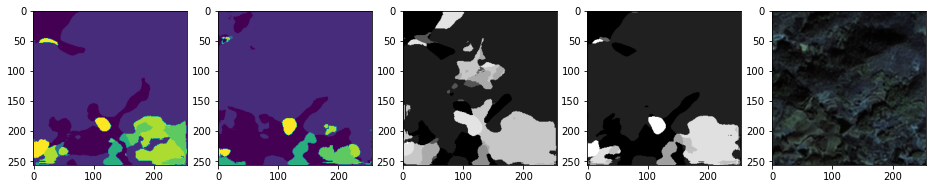

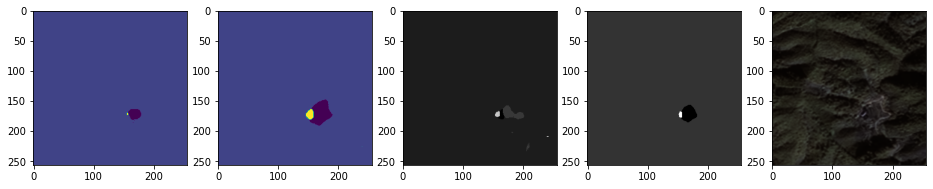

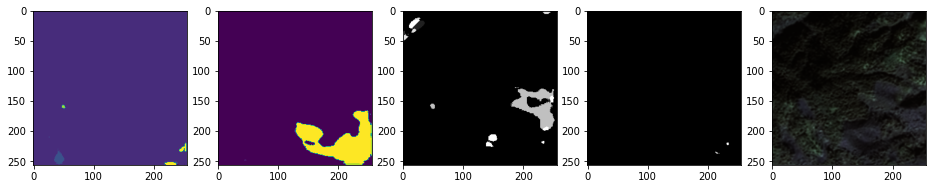

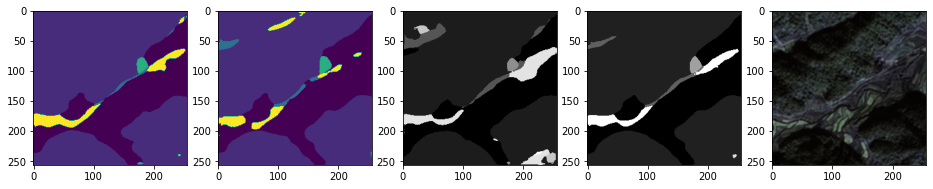

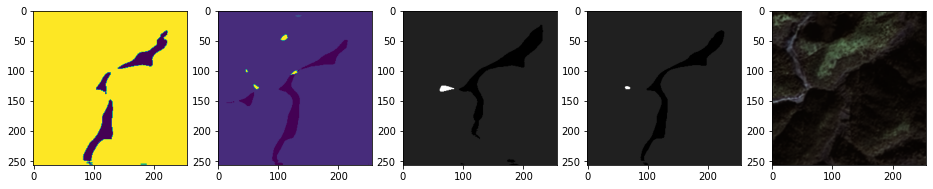

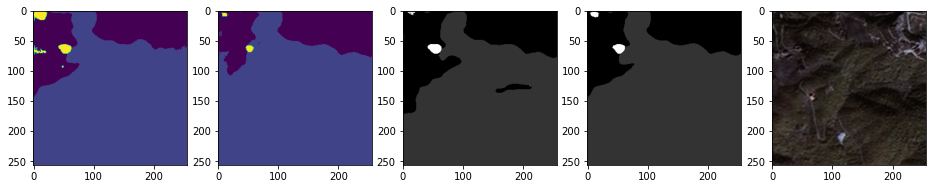

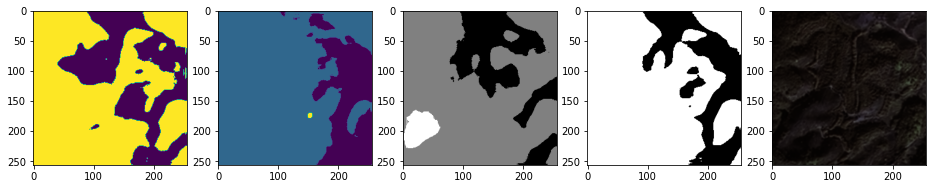

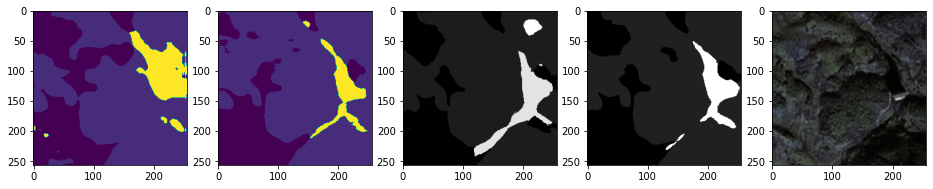

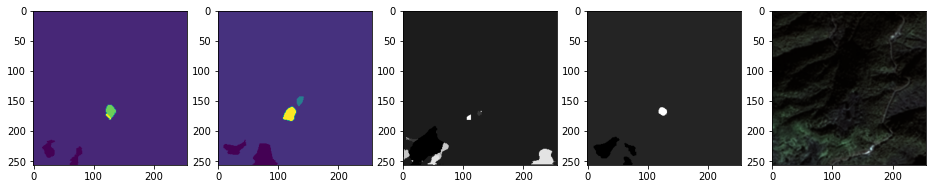

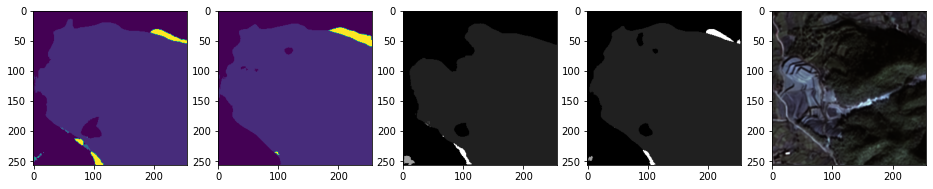

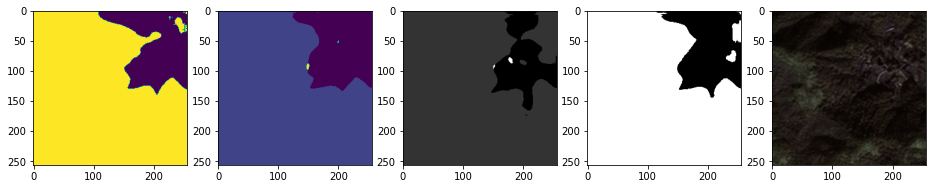

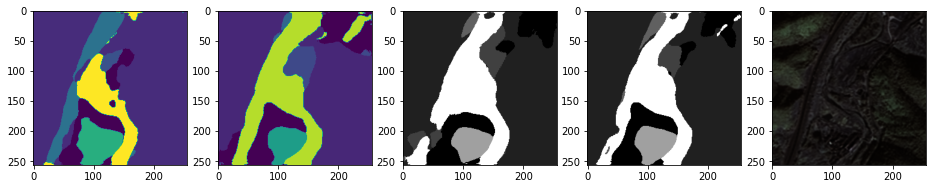

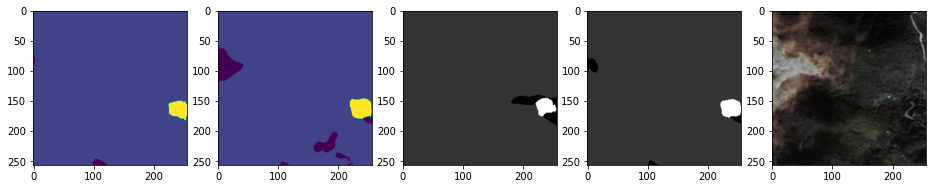

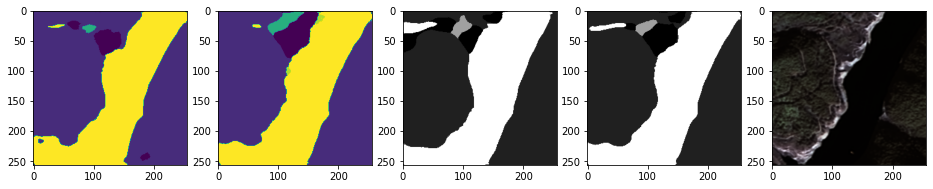

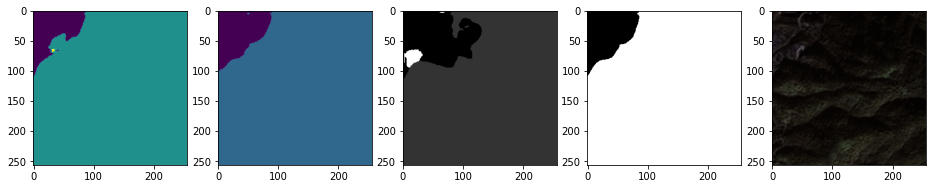

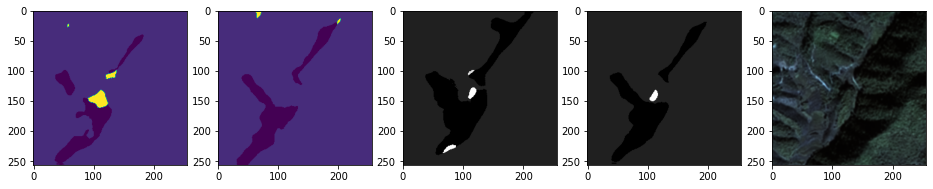

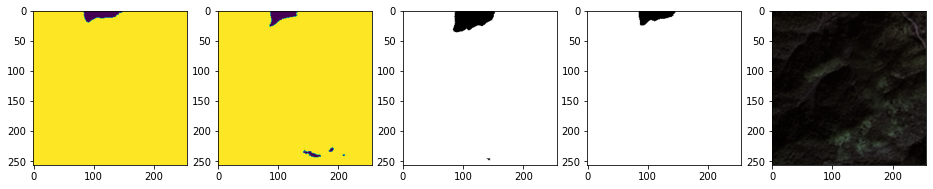

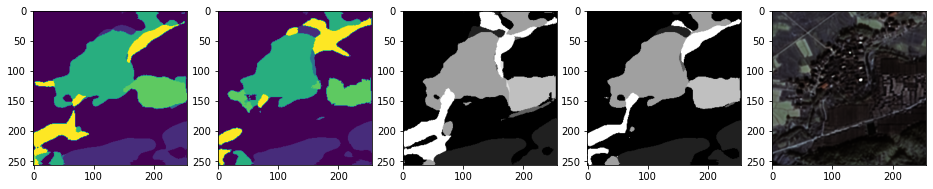

<Figure size 1152x576 with 0 Axes>

In [26]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

import segmentation_models_pytorch as smp
model = smp.Unet(
            encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",     # use `imagenet` pretreined weights for encoder initialization
            in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
            classes=10,                      # model output channels (number of classes in  dataset)
    )
model.to(DEVICE);

model.load_state_dict(torch.load("/content/model_5.pth"))
model.eval()


for idx, name in enumerate(tqdm_notebook(glob.glob('./suichang_round1_test_partA_210120/*.tif')[:])):
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score1 = model(image).cpu().numpy()
        
        score2 = model(torch.flip(image, [0, 3]))
#         score2 = score2.cpu().numpy()
        score2 = torch.flip(score2, [3, 0]).cpu().numpy()

        score3 = model(torch.flip(image, [0, 2]))
#         score3 = score3.cpu().numpy()
        score3 = torch.flip(score3, [2, 0]).cpu().numpy()
        
        score = (score1 + score2 + score3) / 3.0
        
        score_sigmoid = score[0].argmax(0) + 1
        # cv2.imwrite('/content/results/' + name.split('/')[-1].replace('.tif', '.png'), score_sigmoid)
#       score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        plt.figure(figsize=(16,8))
        plt.subplot(151)
        plt.imshow((score1[0].argmax(0) + 1)*30)
        plt.subplot(152)
        plt.imshow((score2[0].argmax(0) + 1)*30)
        plt.subplot(153)
        plt.imshow((score3[0].argmax(0) + 1)*30, cmap='gray')
        plt.subplot(154)
        plt.imshow((score[0].argmax(0) + 1)*30, cmap='gray')
        plt.subplot(155)
        image = cv2.imread(name)
        plt.imshow(image);
        #print(score_sigmoid.min(), score_sigmoid.max())
        
    # break

In [ ]:
score.shape, score3.shape

((1, 10, 256, 256), (1, 10, 256, 256))

In [23]:
!find /content/results/ -name "*.tif" | xargs rm


In [ ]:
!zip -r results.zip results

In [ ]:
glob.glob('./suichang_round1_train_210120/*.tif')[:10]

['./suichang_round1_train_210120/009314.tif',
 './suichang_round1_train_210120/003999.tif',
 './suichang_round1_train_210120/001971.tif',
 './suichang_round1_train_210120/010373.tif',
 './suichang_round1_train_210120/005000.tif',
 './suichang_round1_train_210120/013020.tif',
 './suichang_round1_train_210120/008068.tif',
 './suichang_round1_train_210120/009338.tif',
 './suichang_round1_train_210120/009049.tif',
 './suichang_round1_train_210120/006622.tif']

In [ ]:
cv2.imread('suichang_round1_train_210120/008649.png').min()

1

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/MyDrive/code/tianchi/model_2.pth    /content/

In [2]:
!cp /content/gdrive/MyDrive/code/tianchi/suichang_round1_test_partA_210120.zip    /content/

In [3]:
!cp /content/gdrive/MyDrive/code/tianchi/suichang_round1_train_210120.zip    /content/

In [19]:
!cp -r /content/suichang_round1_test_partA_210120  /content/results

In [ ]:
!mv /content/model_2.pth  /content/gdrive/MyDrive/code/tianchi

In [ ]:
!mv /content/suichang_round1_test_partA_210120.zip  /content/gdrive/MyDrive/code/tianchi

In [ ]:
!mv /content/suichang_round1_train_210120.zip   /content/gdrive/MyDrive/code/tianchi